The purpose of this notebook is to document data exploration processes with an n=50,000 sample of our Learn2Therm protein database. Doing so provides a workspace to select and optimize a model for predicting protein pair functionality between two sequences. Several classifier architectures were tested prior to the release of the final version of this component.

This notebook includes exploration of a Random Forest Classifier.

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.ensemble
import sklearn.feature_selection
import unittest
import iFeatureOmegaCLI
import Bio.SeqIO

In [33]:
cd /Users/loganroberts/Learn2Therm/ValidProt/FAFSA

/Users/loganroberts/Learn2Therm/ValidProt/FAFSA


In [34]:
#convert to pandas df
df = pd.read_csv('learn2therm_sample_50k.csv')

In [35]:
cd /Users/loganroberts/Learn2Therm/ValidProt/notebooks

/Users/loganroberts/Learn2Therm/ValidProt/notebooks


In [36]:
#this function is only necessary if we get a fasta file with a descriptor generated from component 3

def remove_fasta_description(filename:str):
    
    """
    Removes description from fasta file so that iProtein can read the input.
    """
    
    #assign unwanted string to object
    string_to_remove = "<unknown description>"

    #open file
    with open(filename, "r") as file:
        content = file.read()
    
    # Remove the string
    new_content = content.replace(string_to_remove, "")

    #overwrite file without string
    with open(filename, "w") as file:
        seq = file.write(new_content)
        
    return seq

In [37]:
def get_protein_descriptors(sequences:str, descriptors=[]):
    
    """
    Input: Fasta file with protein sequences. 
    Must be a .txt file.
    
    Output: Vector of descriptors
    """
    
    #create iProtein object
    protein = iFeatureOmegaCLI.iProtein(sequences)
    
    #not sure why we need this yet. Right now it is stored in local directory.
    params = protein.import_parameters('protein_parameters.json')
    
    protein_descriptors = {}
    
    for descriptor in descriptors:
        protein.get_descriptor(descriptor)
        protein_descriptors.update({f'{descriptor}':protein.encodings})
        
    return protein_descriptors

In [64]:
protein = iFeatureOmegaCLI.iProtein('meso_input_copy.fasta')

In [65]:
protein.display_feature_types()


        ----- Available feature types ------        
        
        AAC                                                Amino acid composition
        EAAC                                               Enhanced amino acid composition
        CKSAAP type 1                                      Composition of k-spaced amino acid pairs type 1 - normalized
        CKSAAP type 2                                      Composition of k-spaced amino acid pairs type 2 - raw count
        DPC type 1                                         Dipeptide composition type 1 - normalized
        DPC type 2                                         Dipeptide composition type 2 - raw count
        TPC type 1                                         Tripeptide composition type 1 - normalized
        TPC type 2                                         Tripeptide composition type 1 - raw count
        CTDC                                               Composition
        CTDT                                      

In [38]:
get_protein_descriptors("meso_input_copy.fasta.txt", descriptors=['AAC', 'GAAC'])

File imported successfully.


{'AAC':           AAC_A     AAC_C     AAC_D     AAC_E     AAC_F     AAC_G     AAC_H  \
 12897  0.145631  0.009709  0.072816  0.067961  0.014563  0.067961  0.019417   
 13026  0.064378  0.000000  0.115880  0.068670  0.030043  0.051502  0.008584   
 8203   0.205575  0.006969  0.062718  0.034843  0.031359  0.094077  0.020906   
 3340   0.119658  0.000000  0.012821  0.042735  0.055556  0.094017  0.004274   
 14020  0.050000  0.000000  0.025000  0.050000  0.100000  0.075000  0.012500   
 ...         ...       ...       ...       ...       ...       ...       ...   
 3888   0.184906  0.011321  0.075472  0.049057  0.026415  0.109434  0.011321   
 2837   0.136364  0.007576  0.041667  0.075758  0.034091  0.090909  0.026515   
 15339  0.114007  0.003257  0.039088  0.048860  0.042345  0.074919  0.026059   
 13840  0.145631  0.009709  0.067961  0.043689  0.029126  0.053398  0.058252   
 11636  0.141379  0.003448  0.051724  0.065517  0.003448  0.093103  0.027586   
 
           AAC_I     AAC_K     

In [39]:
#combine both of the above functions

def fasta_to_descriptors(fasta:str):

    #remove description from fasta file
    remove_fasta_description(fasta)
    
    #return protein descriptors
    return get_protein_descriptors(fasta, descriptors=['AAC', 'GAAC'])

In [40]:
df2 = fasta_to_descriptors("meso_input_copy.fasta")['AAC']
df2

File imported successfully.


,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,AAC_M,AAC_N,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y
12897,0.145631,0.009709,0.072816,0.067961,0.014563,0.067961,0.019417,0.014563,0.014563,0.106796,0.009709,0.004854,0.053398,0.038835,0.131068,0.033981,0.048544,0.106796,0.009709,0.029126
13026,0.064378,0.000000,0.115880,0.068670,0.030043,0.051502,0.008584,0.051502,0.055794,0.107296,0.055794,0.025751,0.025751,0.042918,0.090129,0.042918,0.047210,0.081545,0.004292,0.030043
8203,0.205575,0.006969,0.062718,0.034843,0.031359,0.094077,0.020906,0.024390,0.010453,0.094077,0.010453,0.020906,0.034843,0.013937,0.104530,0.031359,0.055749,0.114983,0.010453,0.017422
3340,0.119658,0.000000,0.012821,0.042735,0.055556,0.094017,0.004274,0.059829,0.038462,0.153846,0.029915,0.008547,0.047009,0.025641,0.051282,0.055556,0.051282,0.094017,0.029915,0.025641
14020,0.050000,0.000000,0.025000,0.050000,0.100000,0.075000,0.012500,0.062500,0.012500,0.100000,0.050000,0.037500,0.050000,0.037500,0.087500,0.037500,0.025000,0.087500,0.037500,0.062500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3888,0.184906,0.011321,0.075472,0.049057,0.026415,0.109434,0.011321,0.011321,0.015094,0.143396,0.015094,0.003774,0.052830,0.030189,0.071698,0.033962,0.045283,0.094340,0.007547,0.007547
2837,0.136364,0.007576,0.041667,0.075758,0.034091,0.090909,0.026515,0.049242,0.022727,0.121212,0.030303,0.041667,0.026515,0.041667,0.087121,0.056818,0.034091,0.049242,0.003788,0.022727
15339,0.114007,0.003257,0.039088,0.048860,0.042345,0.074919,0.026059,0.045603,0.052117,0.127036,0.022801,0.022801,0.055375,0.039088,0.052117,0.065147,0.055375,0.078176,0.013029,0.022801
13840,0.145631,0.009709,0.067961,0.043689,0.029126,0.053398,0.058252,0.063107,0.004854,0.097087,0.004854,0.009709,0.053398,0.024272,0.101942,0.053398,0.038835,0.092233,0.029126,0.019417


Let's try and align the dataframe with generated features by index.

Note: This requires input of the same AA's, which we dont have rn.

In [41]:
df.set_index('meso_index').sort_index()

,Unnamed: 0,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,thermo_index,...,bit_score_16s,m_ogt,t_ogt,ogt_difference,m_protein_seq,t_protein_seq,m_protein_desc,t_protein_desc,m_protein_len,t_protein_len
meso_index,,,,,,,,,,,,,,,,,,,,,
5,13251,0.285106,0.259690,0.223706,239,0.926357,238,0.697947,177,14963,...,1155.0,28.0,52.5,24.5,MSQPTPASATPPGGHLLDLRDLHVEFRTQEGVAKVINGVSYHLDAG...,MAKRIEVSGLNAYYGRVRAIEDISMTIEPRSVTAFIGPSGCGKSTF...,ABC transporter ATP-binding protein,phosphate ABC transporter ATP-binding protein ...,341,258
5,22239,0.309783,0.235537,0.230769,184,0.760331,188,0.746032,92,875,...,1153.0,28.0,50.0,22.0,MHIDNTAAIVTGGASGLGAATSQALAERGAKVFAFDLPTAIEGAQG...,MTHRTSTKAPVAVVTGASAGLGLAVTTALTRHGWHVVADARNAARL...,SDR family NAD(P)-dependent oxidoreductase,SDR family oxidoreductase,252,242
5,43963,0.257778,0.207885,0.211679,226,0.810036,223,0.828996,148,875,...,1153.0,28.0,50.0,22.0,MTPDPPFGERWALITGATAGIGAAFAERLASDGWHLVLVARDAGRL...,MTRPFAGATAIVTGAASGIGAEIARQMATGGAFVLATDVAEEPLHA...,SDR family oxidoreductase,SDR family oxidoreductase,269,279
5,32945,0.324873,0.178771,0.188235,196,0.547486,208,0.645963,94,7134,...,1139.0,28.0,52.5,24.5,MDLVSEMTYRRLGDSGLVVSVVGIGCNNFGRKLDLDGTRAVVDAAL...,MQEWNPTRRQLMKAGGLGAAAAVVPSMLAGEAAASSAPSEPKDLIT...,aldo/keto reductase,aldo/keto reductase,322,358
5,49249,0.347826,0.226415,0.261343,203,0.638365,211,0.905579,170,14963,...,1155.0,28.0,52.5,24.5,MTQLQARGLVKSYGPTPALHGITLDVAEGEIVAVTGPSGCGKSTLL...,MIEVRDVRKTFTVRSGRLRRRRTMVRAVDGVSFTVREGEFVGYLGS...,ABC transporter ATP-binding protein,ATP-binding cassette domain-containing protein,233,318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16345,24189,0.350962,0.323009,0.268382,207,0.915929,230,0.723270,118,16507,...,1150.0,30.0,52.0,22.0,MSERVRIDVGEGSPEGANSAYLLPDRGVLIDPGPPTERAWSNLLAG...,MSETERANVHALPISIEYGGRPLTITPVVLETDRGLVLVDVGPEGA...,MBL fold metallo-hydrolase,MBL fold metallo-hydrolase,318,226
16345,46461,0.344444,0.187879,0.195276,199,0.603030,183,0.600000,131,16507,...,1150.0,30.0,52.0,22.0,METGIAQEVTAGDCTDLYYIDTGMYETDEYGAVYVLESERPAVVET...,MERISLSNGAFEGNNNAYLFAGGEDVVLVDTGDWMPATREQLEAEF...,MBL fold metallo-hydrolase,MBL fold metallo-hydrolase,305,330
16345,17892,0.286996,0.224561,0.247104,238,0.835088,220,0.944206,220,16507,...,1150.0,30.0,52.0,22.0,MIEFQSVTYGFEGPPVLEDCSLEIDDGEFVLLAGANGSGKTTLLRH...,MSDADATTSTESAASNEVTTTGADSRRRLDDPILELEGVVKRFGGI...,energy-coupling factor ABC transporter ATP-bin...,ABC transporter ATP-binding protein,233,285


In [42]:
df2.sort_index()

,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,AAC_M,AAC_N,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y
100,0.164000,0.000000,0.076000,0.044000,0.032000,0.108000,0.020000,0.032000,0.008000,0.112000,0.020000,0.032000,0.060000,0.012000,0.072000,0.028000,0.064000,0.104000,0.004000,0.008000
10112,0.096386,0.004016,0.064257,0.068273,0.024096,0.084337,0.024096,0.028112,0.024096,0.156627,0.016064,0.028112,0.048193,0.048193,0.084337,0.040161,0.028112,0.120482,0.000000,0.012048
10144,0.080702,0.003509,0.031579,0.024561,0.098246,0.063158,0.007018,0.126316,0.031579,0.122807,0.028070,0.049123,0.035088,0.035088,0.031579,0.052632,0.045614,0.063158,0.024561,0.045614
10144,0.142259,0.004184,0.041841,0.079498,0.016736,0.083682,0.008368,0.075314,0.050209,0.096234,0.033473,0.037657,0.016736,0.025105,0.041841,0.075314,0.075314,0.071130,0.008368,0.016736
10144,0.086420,0.000000,0.021605,0.024691,0.058642,0.055556,0.006173,0.095679,0.049383,0.145062,0.030864,0.058642,0.043210,0.018519,0.033951,0.077160,0.043210,0.086420,0.015432,0.049383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9754,0.143312,0.000000,0.066879,0.054140,0.022293,0.105096,0.025478,0.025478,0.015924,0.092357,0.012739,0.015924,0.076433,0.022293,0.063694,0.031847,0.057325,0.143312,0.012739,0.012739
9757,0.205993,0.003745,0.052434,0.052434,0.003745,0.089888,0.014981,0.026217,0.007491,0.086142,0.018727,0.026217,0.044944,0.044944,0.071161,0.059925,0.063670,0.104869,0.014981,0.007491
9778,0.116883,0.006494,0.081169,0.064935,0.022727,0.087662,0.022727,0.035714,0.025974,0.136364,0.019481,0.016234,0.045455,0.032468,0.090909,0.022727,0.064935,0.077922,0.003247,0.025974
9931,0.134503,0.005848,0.049708,0.032164,0.017544,0.093567,0.017544,0.020468,0.008772,0.152047,0.035088,0.008772,0.052632,0.055556,0.093567,0.073099,0.040936,0.067251,0.008772,0.032164


In [43]:
df.head()

,Unnamed: 0,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,thermo_index,...,bit_score_16s,m_ogt,t_ogt,ogt_difference,m_protein_seq,t_protein_seq,m_protein_desc,t_protein_desc,m_protein_len,t_protein_len
0,0,0.287582,0.217822,0.215686,160,0.792079,152,0.737864,131,875,...,1153.0,27.5,50.0,22.5,MAESGTSRRADHLVPVPGPDAEPPAVADELLRAVGRGDEQAFGRLY...,MPSQITESERIELAERFERDALPLLDQLYSAALRMTRNPADAEDLV...,ECF RNA polymerase sigma factor SigK,sigma-70 family RNA polymerase sigma factor,206,202
1,1,0.319635,0.295359,0.297872,218,0.919831,226,0.969957,282,11324,...,1014.0,25.0,54.0,29.0,MARIALVDDDRNILTSVSMTLEAEGFEVETYNDGQSALDAFNKRMP...,MRVLLVEDDPNTSRSIEMMLTHANLNVYATDMGEEGIDLAKLYDYD...,response regulator transcription factor,response regulator transcription factor,233,237
2,2,0.279621,0.234127,0.218924,211,0.837302,210,0.731707,96,875,...,1138.0,28.0,50.0,22.0,MKDTVVFVTGAARGIGAHTARLAVARGARVALVGLEPHLLADLAAE...,MTPEQIFSGQTAIVTGGASGIGAATVEHIARRGGRVFSVDLSYDSP...,SDR family oxidoreductase,SDR family oxidoreductase,287,252
3,3,0.327273,0.200743,0.214712,166,0.617100,163,0.696581,175,875,...,1077.0,28.0,50.0,22.0,MTSGLWERVLDGVWVTIQLLVLSALLATAVSFVVGIARTHRLWIVR...,MAMSRRKRGQLARGIQYAILVIVVVVLALLADWGKIGKAFFDWEAA...,ectoine/hydroxyectoine ABC transporter permeas...,amino acid ABC transporter permease,234,269
4,4,0.338710,0.318182,0.287671,60,0.909091,71,0.887500,61,9827,...,991.0,30.0,50.0,20.0,MIISLRRGLRFIRFIVFFAALVYLFYHVLDLFNGWISPVDQYQMPT...,MKRMVWRTLKVFIIFIACTLLFYFGLRFMHLEYEQFHRYEPPEGPA...,YqzK family protein,YqzK family protein,80,66


In [44]:
df_seqs = df[['meso_index', 'm_protein_seq']]
df_seqs.head()

,meso_index,m_protein_seq
0,12897,MAESGTSRRADHLVPVPGPDAEPPAVADELLRAVGRGDEQAFGRLY...
1,13026,MARIALVDDDRNILTSVSMTLEAEGFEVETYNDGQSALDAFNKRMP...
2,8203,MKDTVVFVTGAARGIGAHTARLAVARGARVALVGLEPHLLADLAAE...
3,3340,MTSGLWERVLDGVWVTIQLLVLSALLATAVSFVVGIARTHRLWIVR...
4,14020,MIISLRRGLRFIRFIVFFAALVYLFYHVLDLFNGWISPVDQYQMPT...


In [45]:
small_df = df.set_index('meso_index')[:10]
small_df

,Unnamed: 0,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,thermo_index,...,bit_score_16s,m_ogt,t_ogt,ogt_difference,m_protein_seq,t_protein_seq,m_protein_desc,t_protein_desc,m_protein_len,t_protein_len
meso_index,,,,,,,,,,,,,,,,,,,,,
12897,0,0.287582,0.217822,0.215686,160,0.792079,152,0.737864,131,875,...,1153.0,27.5,50.0,22.5,MAESGTSRRADHLVPVPGPDAEPPAVADELLRAVGRGDEQAFGRLY...,MPSQITESERIELAERFERDALPLLDQLYSAALRMTRNPADAEDLV...,ECF RNA polymerase sigma factor SigK,sigma-70 family RNA polymerase sigma factor,206,202
13026,1,0.319635,0.295359,0.297872,218,0.919831,226,0.969957,282,11324,...,1014.0,25.0,54.0,29.0,MARIALVDDDRNILTSVSMTLEAEGFEVETYNDGQSALDAFNKRMP...,MRVLLVEDDPNTSRSIEMMLTHANLNVYATDMGEEGIDLAKLYDYD...,response regulator transcription factor,response regulator transcription factor,233,237
8203,2,0.279621,0.234127,0.218924,211,0.837302,210,0.731707,96,875,...,1138.0,28.0,50.0,22.0,MKDTVVFVTGAARGIGAHTARLAVARGARVALVGLEPHLLADLAAE...,MTPEQIFSGQTAIVTGGASGIGAATVEHIARRGGRVFSVDLSYDSP...,SDR family oxidoreductase,SDR family oxidoreductase,287,252
3340,3,0.327273,0.200743,0.214712,166,0.617100,163,0.696581,175,875,...,1077.0,28.0,50.0,22.0,MTSGLWERVLDGVWVTIQLLVLSALLATAVSFVVGIARTHRLWIVR...,MAMSRRKRGQLARGIQYAILVIVVVVLALLADWGKIGKAFFDWEAA...,ectoine/hydroxyectoine ABC transporter permeas...,amino acid ABC transporter permease,234,269
14020,4,0.338710,0.318182,0.287671,60,0.909091,71,0.887500,61,9827,...,991.0,30.0,50.0,20.0,MIISLRRGLRFIRFIVFFAALVYLFYHVLDLFNGWISPVDQYQMPT...,MKRMVWRTLKVFIIFIACTLLFYFGLRFMHLEYEQFHRYEPPEGPA...,YqzK family protein,YqzK family protein,80,66
3582,5,0.333333,0.267380,0.254453,148,0.791444,163,0.791262,127,8919,...,942.0,17.5,42.0,24.5,MVTTGERQRNARGEGARLRLEIVAATQALLADGETATLRSIARRAG...,MNRPTYHHGDLRAAILTEAARLVAERGAERVSLRELAREAGVSHAA...,TetR/AcrR family transcriptional regulator,TetR/AcrR family transcriptional regulator,206,187
13920,6,0.283582,0.231707,0.240506,133,0.810976,134,0.881579,99,7134,...,1011.0,28.0,52.5,24.5,MGSTDRPDLAAMLAPLTRTLIAMERPVLETYGLTMWAYSVLVALSR...,MGHKDELIARIQRAEREFRRSVVSQAATDFFSVDLTMPQLRVVFFL...,MarR family transcriptional regulator,MarR family transcriptional regulator,152,164
6370,7,0.268482,0.190083,0.189300,248,0.683196,271,0.740437,132,14963,...,1054.0,27.0,52.5,25.5,MPRWVKIAVIVAVAAIVGVASVPLSQLGSGTITVTAQFADAAGLYN...,MKVPFRERNPVPIALASFTALAVLMLGAYFIEDLPVIGGGTTYSAR...,MCE family protein,MCE family protein,366,363
9289,8,0.265306,0.201550,0.210243,320,0.826873,294,0.828169,140,1674,...,1011.0,30.0,57.5,27.5,MSITTKEKRFGIIERYREFLPVTENTPKLTLHEGDTPLIHAASLSA...,MSGVEIEKGYFGQFGGSFVFPELQEVLDYLAEQFERYKDDPEFKQE...,threonine synthase,tryptophan synthase subunit beta,355,387


In [54]:
small_50k = learn2therm_50k[:10]
small_50k

,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,AAC_M,AAC_N,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y
12897,0.145631,0.009709,0.072816,0.067961,0.014563,0.067961,0.019417,0.014563,0.014563,0.106796,0.009709,0.004854,0.053398,0.038835,0.131068,0.033981,0.048544,0.106796,0.009709,0.029126
13026,0.064378,0.000000,0.115880,0.068670,0.030043,0.051502,0.008584,0.051502,0.055794,0.107296,0.055794,0.025751,0.025751,0.042918,0.090129,0.042918,0.047210,0.081545,0.004292,0.030043
8203,0.205575,0.006969,0.062718,0.034843,0.031359,0.094077,0.020906,0.024390,0.010453,0.094077,0.010453,0.020906,0.034843,0.013937,0.104530,0.031359,0.055749,0.114983,0.010453,0.017422
3340,0.119658,0.000000,0.012821,0.042735,0.055556,0.094017,0.004274,0.059829,0.038462,0.153846,0.029915,0.008547,0.047009,0.025641,0.051282,0.055556,0.051282,0.094017,0.029915,0.025641
14020,0.050000,0.000000,0.025000,0.050000,0.100000,0.075000,0.012500,0.062500,0.012500,0.100000,0.050000,0.037500,0.050000,0.037500,0.087500,0.037500,0.025000,0.087500,0.037500,0.062500
3582,0.179612,0.004854,0.092233,0.043689,0.033981,0.063107,0.029126,0.033981,0.009709,0.101942,0.024272,0.014563,0.038835,0.024272,0.106796,0.043689,0.048544,0.072816,0.019417,0.014563
13920,0.131579,0.000000,0.085526,0.065789,0.006579,0.052632,0.026316,0.039474,0.006579,0.157895,0.026316,0.006579,0.052632,0.052632,0.105263,0.059211,0.052632,0.052632,0.006579,0.013158
6370,0.139344,0.005464,0.081967,0.019126,0.021858,0.103825,0.008197,0.054645,0.032787,0.103825,0.024590,0.043716,0.027322,0.046448,0.060109,0.054645,0.071038,0.084699,0.002732,0.013661
9289,0.132394,0.014085,0.042254,0.070423,0.025352,0.087324,0.005634,0.084507,0.059155,0.078873,0.019718,0.045070,0.053521,0.030986,0.033803,0.053521,0.064789,0.064789,0.002817,0.030986
742,0.136000,0.008000,0.056000,0.056000,0.024000,0.116000,0.008000,0.072000,0.044000,0.092000,0.020000,0.032000,0.048000,0.028000,0.052000,0.048000,0.048000,0.100000,0.000000,0.012000


In [67]:
df3= pd.merge(small_df, small_50k.sort_index(), how='outer', left_index=True, right_index=True)
df3

,Unnamed: 0,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,thermo_index,...,AAC_M,AAC_N,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y
742,9.0,0.333333,0.295082,0.291498,218.0,0.893443,221.0,0.884000,158.0,875.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3340,3.0,0.327273,0.200743,0.214712,166.0,0.617100,163.0,0.696581,175.0,875.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3582,5.0,0.333333,0.267380,0.254453,148.0,0.791444,163.0,0.791262,127.0,8919.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6370,7.0,0.268482,0.190083,0.189300,248.0,0.683196,271.0,0.740437,132.0,14963.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8203,2.0,0.279621,0.234127,0.218924,211.0,0.837302,210.0,0.731707,96.0,875.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9289,8.0,0.265306,0.201550,0.210243,320.0,0.826873,294.0,0.828169,140.0,1674.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12897,0.0,0.287582,0.217822,0.215686,160.0,0.792079,152.0,0.737864,131.0,875.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13026,1.0,0.319635,0.295359,0.297872,218.0,0.919831,226.0,0.969957,282.0,11324.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13920,6.0,0.283582,0.231707,0.240506,133.0,0.810976,134.0,0.881579,99.0,7134.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14020,4.0,0.338710,0.318182,0.287671,60.0,0.909091,71.0,0.887500,61.0,9827.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
print(df3.index)

Index([    742,    3340,    3582,    6370,    8203,    9289,   12897,   13026,
         13920,   14020, '12897', '13026', '13920', '14020',  '3340',  '3582',
        '6370',   '742',  '8203',  '9289'],
      dtype='object')


In [70]:
# write the dataframe to a fasta file
#adjust this to write function with BioPython

with open('meso_50k.fasta', 'w') as f:
    for i, row in df.iterrows():
        f.write('>{}\n{}\n'.format(row['meso_index'], row['m_protein_seq']))


In [57]:
learn2therm_50k = get_protein_descriptors('meso_50k.fasta', descriptors=['AAC', 'GAAC'])['AAC']
learn2therm_50k.head()
#why does this not require a .txt file? I think it accepts fasta, just needs descriptor to be gone

File imported successfully.


,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,AAC_M,AAC_N,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y
12897,0.145631,0.009709,0.072816,0.067961,0.014563,0.067961,0.019417,0.014563,0.014563,0.106796,0.009709,0.004854,0.053398,0.038835,0.131068,0.033981,0.048544,0.106796,0.009709,0.029126
13026,0.064378,0.000000,0.115880,0.068670,0.030043,0.051502,0.008584,0.051502,0.055794,0.107296,0.055794,0.025751,0.025751,0.042918,0.090129,0.042918,0.047210,0.081545,0.004292,0.030043
8203,0.205575,0.006969,0.062718,0.034843,0.031359,0.094077,0.020906,0.024390,0.010453,0.094077,0.010453,0.020906,0.034843,0.013937,0.104530,0.031359,0.055749,0.114983,0.010453,0.017422
3340,0.119658,0.000000,0.012821,0.042735,0.055556,0.094017,0.004274,0.059829,0.038462,0.153846,0.029915,0.008547,0.047009,0.025641,0.051282,0.055556,0.051282,0.094017,0.029915,0.025641
14020,0.050000,0.000000,0.025000,0.050000,0.100000,0.075000,0.012500,0.062500,0.012500,0.100000,0.050000,0.037500,0.050000,0.037500,0.087500,0.037500,0.025000,0.087500,0.037500,0.062500


In [58]:
df.set_index('meso_index').head()

,Unnamed: 0,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,thermo_index,...,bit_score_16s,m_ogt,t_ogt,ogt_difference,m_protein_seq,t_protein_seq,m_protein_desc,t_protein_desc,m_protein_len,t_protein_len
meso_index,,,,,,,,,,,,,,,,,,,,,
12897,0,0.287582,0.217822,0.215686,160,0.792079,152,0.737864,131,875,...,1153.0,27.5,50.0,22.5,MAESGTSRRADHLVPVPGPDAEPPAVADELLRAVGRGDEQAFGRLY...,MPSQITESERIELAERFERDALPLLDQLYSAALRMTRNPADAEDLV...,ECF RNA polymerase sigma factor SigK,sigma-70 family RNA polymerase sigma factor,206,202
13026,1,0.319635,0.295359,0.297872,218,0.919831,226,0.969957,282,11324,...,1014.0,25.0,54.0,29.0,MARIALVDDDRNILTSVSMTLEAEGFEVETYNDGQSALDAFNKRMP...,MRVLLVEDDPNTSRSIEMMLTHANLNVYATDMGEEGIDLAKLYDYD...,response regulator transcription factor,response regulator transcription factor,233,237
8203,2,0.279621,0.234127,0.218924,211,0.837302,210,0.731707,96,875,...,1138.0,28.0,50.0,22.0,MKDTVVFVTGAARGIGAHTARLAVARGARVALVGLEPHLLADLAAE...,MTPEQIFSGQTAIVTGGASGIGAATVEHIARRGGRVFSVDLSYDSP...,SDR family oxidoreductase,SDR family oxidoreductase,287,252
3340,3,0.327273,0.200743,0.214712,166,0.617100,163,0.696581,175,875,...,1077.0,28.0,50.0,22.0,MTSGLWERVLDGVWVTIQLLVLSALLATAVSFVVGIARTHRLWIVR...,MAMSRRKRGQLARGIQYAILVIVVVVLALLADWGKIGKAFFDWEAA...,ectoine/hydroxyectoine ABC transporter permeas...,amino acid ABC transporter permease,234,269
14020,4,0.338710,0.318182,0.287671,60,0.909091,71,0.887500,61,9827,...,991.0,30.0,50.0,20.0,MIISLRRGLRFIRFIVFFAALVYLFYHVLDLFNGWISPVDQYQMPT...,MKRMVWRTLKVFIIFIACTLLFYFGLRFMHLEYEQFHRYEPPEGPA...,YqzK family protein,YqzK family protein,80,66


In [59]:
df_joined = pd.concat([df.set_index('meso_index'), learn2therm_50k], axis=0)
df_joined

,Unnamed: 0,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,thermo_index,...,AAC_M,AAC_N,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y
12897,0.0,0.287582,0.217822,0.215686,160.0,0.792079,152.0,0.737864,131.0,875.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13026,1.0,0.319635,0.295359,0.297872,218.0,0.919831,226.0,0.969957,282.0,11324.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8203,2.0,0.279621,0.234127,0.218924,211.0,0.837302,210.0,0.731707,96.0,875.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3340,3.0,0.327273,0.200743,0.214712,166.0,0.617100,163.0,0.696581,175.0,875.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14020,4.0,0.338710,0.318182,0.287671,60.0,0.909091,71.0,0.887500,61.0,9827.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.011070,0.014760,0.081181,0.022140,0.073801,0.036900,0.055351,0.081181,0.036900,0.007380
1395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.010000,0.005000,0.025000,0.020000,0.120000,0.060000,0.030000,0.150000,0.005000,0.015000
8513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.015106,0.012085,0.060423,0.057402,0.063444,0.030211,0.057402,0.078550,0.009063,0.012085
4295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.016807,0.008403,0.046218,0.016807,0.096639,0.071429,0.029412,0.088235,0.004202,0.008403


In [60]:
learn2therm_50k

,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,AAC_M,AAC_N,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y
12897,0.145631,0.009709,0.072816,0.067961,0.014563,0.067961,0.019417,0.014563,0.014563,0.106796,0.009709,0.004854,0.053398,0.038835,0.131068,0.033981,0.048544,0.106796,0.009709,0.029126
13026,0.064378,0.000000,0.115880,0.068670,0.030043,0.051502,0.008584,0.051502,0.055794,0.107296,0.055794,0.025751,0.025751,0.042918,0.090129,0.042918,0.047210,0.081545,0.004292,0.030043
8203,0.205575,0.006969,0.062718,0.034843,0.031359,0.094077,0.020906,0.024390,0.010453,0.094077,0.010453,0.020906,0.034843,0.013937,0.104530,0.031359,0.055749,0.114983,0.010453,0.017422
3340,0.119658,0.000000,0.012821,0.042735,0.055556,0.094017,0.004274,0.059829,0.038462,0.153846,0.029915,0.008547,0.047009,0.025641,0.051282,0.055556,0.051282,0.094017,0.029915,0.025641
14020,0.050000,0.000000,0.025000,0.050000,0.100000,0.075000,0.012500,0.062500,0.012500,0.100000,0.050000,0.037500,0.050000,0.037500,0.087500,0.037500,0.025000,0.087500,0.037500,0.062500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8772,0.158672,0.007380,0.092251,0.040590,0.036900,0.088561,0.014760,0.018450,0.011070,0.110701,0.011070,0.014760,0.081181,0.022140,0.073801,0.036900,0.055351,0.081181,0.036900,0.007380
1395,0.105000,0.000000,0.065000,0.090000,0.030000,0.080000,0.020000,0.040000,0.030000,0.100000,0.010000,0.005000,0.025000,0.020000,0.120000,0.060000,0.030000,0.150000,0.005000,0.015000
8513,0.126888,0.003021,0.063444,0.057402,0.018127,0.105740,0.021148,0.069486,0.024169,0.114804,0.015106,0.012085,0.060423,0.057402,0.063444,0.030211,0.057402,0.078550,0.009063,0.012085
4295,0.168067,0.000000,0.046218,0.054622,0.029412,0.126050,0.004202,0.008403,0.016807,0.159664,0.016807,0.008403,0.046218,0.016807,0.096639,0.071429,0.029412,0.088235,0.004202,0.008403


In [71]:
# check if the index is properly aligned
print(df.set_index('meso_index').reset_index().index.equals(learn2therm_50k.sort_index().index))

False


Scratch work for above function

In [28]:
sequence = "meso_input_copy.fasta.txt"
string_to_remove = "<unknown description>"

with open(sequence, "r") as file:
    content = file.read()
    
# Remove the string
new_content = content.replace(string_to_remove, "")

with open(sequence, "w") as file:
    file.write(new_content)


In [24]:
#just figured out that iFeature cannot read the <unknown descriptor> part of the fasta sequence


protein = iFeatureOmegaCLI.iProtein('meso_input_copy.fasta.txt')

In [70]:
protein.display_feature_types()


        ----- Available feature types ------        
        
        AAC                                                Amino acid composition
        EAAC                                               Enhanced amino acid composition
        CKSAAP type 1                                      Composition of k-spaced amino acid pairs type 1 - normalized
        CKSAAP type 2                                      Composition of k-spaced amino acid pairs type 2 - raw count
        DPC type 1                                         Dipeptide composition type 1 - normalized
        DPC type 2                                         Dipeptide composition type 2 - raw count
        TPC type 1                                         Tripeptide composition type 1 - normalized
        TPC type 2                                         Tripeptide composition type 1 - raw count
        CTDC                                               Composition
        CTDT                                      

In [21]:
df['t_protein_len'].describe()

count    50000.000000
mean       261.367700
std         69.675548
min         27.000000
25%        226.000000
50%        260.000000
75%        311.000000
max        400.000000
Name: t_protein_len, dtype: float64

The bit-score provides a better rule-of-thumb for inferring homology. For average length proteins, a bit score of 50 is almost always significant. A bit score of 40 is only significant (E() < 0.001) in searches of protein databases with fewer than 7000 entries. Increasing the score by 10 bits increases the significance 210=1000-fold, so 50 bits would be significant in a database with less than 7 million entries (10 times SwissProt, and within a factor of 3 of the largest protein databases). Thus, the NCBI Blast web site uses a color code of blue for alignment with scores between 40–50 bits; and green for scores between 50–80 bits. In the yeast vs human example, the alignments with less than 20% identity had scores ranging from 55 – 170 bits. Except for very long proteins and very large databases, 50 bits of similarity score will always be statistically significant and is a much better rule-of-thumb for inferring homology in protein alignments.

Pearson et al., 2013: An Introduction to Sequence Similarity (“Homology”) Searching

In [9]:
df['protein_match'] = ((df['bit_score'] > 50 ) & (df['query_align_cov'] > 0.8))

In [10]:
df['protein_match'].value_counts()

True     25887
False    24113
Name: protein_match, dtype: int64

In [11]:
#get rid of stuff that isn't quantitative

df = df.drop(columns = ['Unnamed: 0','thermo_index', 'm_protein_seq', 't_protein_seq',
                        'm_protein_desc', 't_protein_desc'])

In [12]:
df.head()

,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,meso_index,prot_pair_index,...,scaled_local_symmetric_percent_id_16s,query_align_cov_16s,subject_align_cov_16s,bit_score_16s,m_ogt,t_ogt,ogt_difference,m_protein_len,t_protein_len,protein_match
0,0.287582,0.217822,0.215686,160,0.792079,152,0.737864,131,12897,48641291,...,0.926461,0.998040,0.998020,1153.0,27.5,50.0,22.5,206,202,False
1,0.319635,0.295359,0.297872,218,0.919831,226,0.969957,282,13026,92992745,...,0.902522,1.000000,1.000000,1014.0,25.0,54.0,29.0,233,237,True
2,0.279621,0.234127,0.218924,211,0.837302,210,0.731707,96,8203,157628663,...,0.923531,1.000000,1.000000,1138.0,28.0,50.0,22.0,287,252,True
3,0.327273,0.200743,0.214712,166,0.617100,163,0.696581,175,3340,136708305,...,0.909745,0.996734,0.996726,1077.0,28.0,50.0,22.0,234,269,False
4,0.338710,0.318182,0.287671,60,0.909091,71,0.887500,61,14020,133672542,...,0.887107,0.998084,0.998067,991.0,30.0,50.0,20.0,80,66,True


From pairplot below, it looks like query_align_cov_16s and subject_align_cov_16s dont correlate with target. Let's remove them.

In [13]:
# sns.pairplot(df.sample(500),height = 4)

In [14]:
df = df.drop(columns = ['query_align_cov_16s', 'subject_align_cov_16s'])

In [15]:
df.describe()

,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,meso_index,prot_pair_index,...,taxa_pair_index,local_gap_compressed_percent_id_16s,scaled_local_query_percent_id_16s,scaled_local_symmetric_percent_id_16s,bit_score_16s,m_ogt,t_ogt,ogt_difference,m_protein_len,t_protein_len
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,5.000000e+04,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.349026,0.276478,0.270792,206.011660,0.791507,205.414920,0.770875,230.63206,8098.858120,9.105934e+07,...,362827.905140,0.906828,0.903266,0.904959,1061.404480,27.348365,51.505410,24.157045,269.985200,261.367700
std,0.096608,0.114404,0.116039,64.260901,0.144893,64.430548,0.179955,186.44859,4608.982941,5.233883e+07,...,229264.926253,0.015240,0.015626,0.015300,75.659661,3.737201,3.816972,3.586797,65.935753,69.675548
min,0.164103,0.081301,0.045977,19.000000,0.284553,19.000000,0.082019,35.00000,5.000000,1.219000e+03,...,4885.000000,0.876590,0.836055,0.880026,891.000000,7.000000,41.000000,20.000000,30.000000,27.000000
25%,0.293750,0.204545,0.202020,172.000000,0.673288,172.000000,0.656854,118.00000,4121.000000,4.645832e+07,...,173976.750000,0.895995,0.893020,0.893531,1009.000000,27.000000,50.000000,22.000000,233.000000,226.000000
50%,0.325000,0.250000,0.244648,210.000000,0.811321,209.000000,0.806584,186.00000,8046.000000,9.160212e+07,...,312362.000000,0.905983,0.902326,0.903543,1056.000000,28.000000,52.500000,24.500000,267.000000,260.000000
75%,0.367257,0.308300,0.301639,240.000000,0.923077,240.000000,0.923077,267.00000,12103.000000,1.360713e+08,...,617814.000000,0.916172,0.912576,0.914698,1108.000000,29.000000,52.500000,24.500000,317.000000,311.000000
max,0.985075,0.985075,0.985075,400.000000,1.000000,399.000000,1.000000,1788.00000,16564.000000,1.814866e+08,...,744518.000000,0.999351,0.993544,0.996439,1679.000000,40.000000,78.000000,56.000000,400.000000,400.000000


Split data into dev and test, and then split that into train and validation.

In [16]:
#drop columns that don't exihibit signficant pearson correlation with bit_score

df = df.drop(columns = ['meso_index', 'meso_protein_int_index', 'local_gap_compressed_percent_id_16s', 
                        'scaled_local_query_percent_id_16s', 'scaled_local_symmetric_percent_id_16s',
                       'bit_score_16s', 'm_ogt', 't_ogt', 'taxa_pair_index', 'thermo_protein_int_index'
                       , 'prot_pair_index', 'ogt_difference'])

In [17]:
#choosing 80/20 split instead of 85/15 because of volume of data

dev, test = sklearn.model_selection.train_test_split(df, test_size=0.15, random_state=1)

train, val = sklearn.model_selection.train_test_split(dev, test_size=0.15, random_state=1)

print(dev.shape)
print(test.shape)
print(train.shape)
print(val.shape)

(42500, 11)
(7500, 11)
(36125, 11)
(6375, 11)


In [18]:
#ID target and features, separate into separate arrays

target = 'protein_match'
input_features = [columns for columns in df]
input_features.remove(target)

In [19]:
print(input_features)
print(target)

['local_gap_compressed_percent_id', 'scaled_local_query_percent_id', 'scaled_local_symmetric_percent_id', 'query_align_len', 'query_align_cov', 'subject_align_len', 'subject_align_cov', 'bit_score', 'm_protein_len', 't_protein_len']
protein_match


In [20]:
#split X and y

dev_X = dev[input_features].values
test_X = test[input_features].values

dev_y = dev[target].values.reshape(-1,1)
test_y = test[target].values.reshape(-1,1)  

print(dev_X.shape, test_X.shape, dev_y.shape, test_y.shape)

(42500, 10) (7500, 10) (42500, 1) (7500, 1)


In [21]:
#same thing for training and validation data

train_X = train[input_features].values
val_X = val[input_features].values

train_y = train[target].values.reshape(-1,1)
val_y = val[target].values.reshape(-1,1) 

Scale the data

In [22]:
scaler = sklearn.preprocessing.StandardScaler()
dev_X = scaler.fit_transform(dev_X)
test_X = scaler.fit_transform(test_X)
train_X = scaler.fit_transform(train_X)
val_X = scaler.fit_transform(val_X)

Train the model

In [23]:
#Random Forest

model = sklearn.ensemble.RandomForestClassifier(n_estimators=150, max_depth=None, max_samples=0.5,
                                                max_features=0.5, min_weight_fraction_leaf=0.000215,
                                               min_samples_split=10)
# model = sklearn.ensemble.RandomForestClassifier()
model.fit(train_X, train_y.ravel())

RandomForestClassifier(max_features=0.5, max_samples=0.5, min_samples_split=10,
                       min_weight_fraction_leaf=0.000215, n_estimators=150)

Test the model, report relevant statistics

In [24]:
score = model.score(val_X, val_y)
print('Model score is: {}'.format(score))

preds = model.predict(test_X)
print(preds)

Model score is: 0.9927843137254901
[False False False ... False  True False]


In [25]:
#confusion matrix

confusion_matrix = sklearn.metrics.confusion_matrix(preds, test_y)
sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix).plot()

Convert the above code into functions.

In [26]:
def train_model(dataframe, columns = [],  target = []):
    """
    Takes dataframe and splits it into a training and testing set. 
    Note: Data is called train and test, but this test set is currently
    closer to a validation set. Keeping nomenclature to keep model robust.
    Trains a KNN classifier model with selected data.
    
    Params
    ----------
    dataframe: Pandas dataframe 
    columns: list of strings, representing input features
    target: list of strings, representing target feature(s)

    Returns
    -------
    -Sk-learn model object
    -train data (features)
    -train data (target)
    -validation data (features)
    -validation data (target)
    """
    #split data
    dev, test = sklearn.model_selection.train_test_split(dataframe, test_size=0.15, random_state=1)
    
    #test input arguments
    assert "pandas.core.frame.DataFrame" in str(type(dev))
    assert "pandas.core.frame.DataFrame" in str(type(test))
    assert "str" in str(type(columns[0]))
    assert "str" in str(type(target[0]))
   
    #split into input and output feature(s)
    dev_X = dev[columns].values
    test_X = test[columns].values

    dev_y = dev[target].values.reshape(-1,1)
    test_y = test[target].values.reshape(-1,1)
    
    #scale data
    scaler = sklearn.preprocessing.StandardScaler()
    dev_X = scaler.fit_transform(dev_X)
    test_X = scaler.fit_transform(test_X)
    
    #train model
    model = sklearn.ensemble.RandomForestClassifier()
    model = model.fit(dev_X, dev_y.ravel())
    
    return model, dev_X, dev_y, test_X, test_y
    

In [27]:
model, dev_X, dev_y, test_X, test_y = train_model(df, columns = input_features, 
                                          target='protein_match')

In [28]:
class TestModelTraining(unittest.TestCase):
    
    def test_invalid_inputs(self):
    
        #test that input data type is correct
        
        try:
            train_model([1,2,3], columns = 'string', target = 'string')
            self.assertTrue(False)
        except AssertionError:
            self.assertTrue(True)
    
#     def test_input_distro(self):
        
#         #test that dev and test features have similar Jensen Shannon Distribution
        
#         JSD = (
#             scipy.stats.bootstrap((train_reg(split_data(df)[0], split_data(df)[1],
#                                 columns = input_features, target=target)[1], train_reg(split_data(df)[0], 
#                                 split_data(df)[1], columns = input_features, target=target)[3]), 
#                                   JSD_dev_and_test, n_resamples=1000, 
#                                   batch=5, method='percentile')
#         )

#         div = JSD.confidence_interval[1]
        
#         #asserts that the divergence between data sets is sufficiently low
#         assert abs(div) < 0.3, "Warning! High JSD between dev and test set!"
        
    def test_output_format(self):
        
        #asserts that function returns 4 objects to be assigned to pearson_corr, model, test_X, test_y
        assert len(train_model(df, columns = input_features, 
                                          target = target)) == 5
        

suite = unittest.TestLoader().loadTestsFromTestCase(TestModelTraining)
_ = unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 2.559s

OK


In [29]:
#need to fix this

def evaluate_model(model, test_X, test_y):
    
    """
    Takes a trained model and test data and tests the model.
    
    Params
    ----------
    model: sklearn.neighbors.KNeighborsClassifier
    test_X: numpy array
    test_y: numpy array

    Returns
    -------
    Vector of predictions based on the model (numpy array)
    """
    
    #test input arguments
    assert "sklearn" in str(type(model))
    assert "numpy.ndarray" in str(type(test_X))
    assert "numpy.ndarray" in str(type(test_y))
    
    preds = model.predict(test_X)
    
    return preds

In [30]:
preds = evaluate_model(model, test_X, test_y)
preds

array([False, False, False, ..., False,  True, False])

In [31]:
class TestModelPerformance(unittest.TestCase):

    def test_asserts(self):
        model, _, _, test_X, test_y = train_model(
            df, columns=input_features, target='protein_match'
        )
        # assert that input types are correct
        with self.assertRaises(AssertionError):
            evaluate_model(model, [1, 2, 3], test_y)
            
    def test_model_output(self):
        model, _, _, test_X, test_y = train_model(
            df, columns=input_features, target='protein_match'
        )
        # assert output type is correct
        output = evaluate_model(model, test_X, test_y)
        self.assertIsInstance(output, np.ndarray)
        
    def test_pred_dimension(self):
        model, _, _, test_X, test_y = train_model(df, 
            columns=input_features, target='protein_match'
        )
        # want to check that the number of predictions is equal to the number of test examples
        preds = evaluate_model(model, test_X, test_y)
        self.assertEqual(len(test_y), len(preds))

suite = unittest.TestLoader().loadTestsFromTestCase(TestModelPerformance)
_ = unittest.TextTestRunner().run(suite)


...
----------------------------------------------------------------------
Ran 3 tests in 8.492s

OK


A good test here can be adding outliers and seeing how much the score and predictions change (probably for the above function).

In [169]:
def plot_model(model, test_X, test_y):
    """
    Takes a test KNN Classifier model and plots the confusion matrix.
    
    Params
    ----------
    model: sklearn.neighbors.KNeighborsClassifier
    test_X: numpy array
    test_y: numpy array

    Returns
    -------
    -Confusion predictions vs. observations
    -Model score
    """
    
    #test input arguments
    assert "sklearn" in str(type(model))
    assert "numpy.ndarray" in str(type(test_X))
    assert "numpy.ndarray" in str(type(test_y))
    
    score = model.score(test_X, test_y)
    preds = evaluate_model(model, test_X, test_y)
   
    # plot confusion matrix
    confusion_matrix = sklearn.metrics.confusion_matrix(preds, test_y)
    cm_plot = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix)
    
    cm_plot.plot(cmap=plt.cm.Blues)
    cm_plot.ax_.set_title('Confusion Matrix')
    
    return score
    

0.9989333333333333

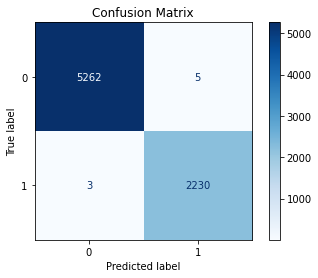

In [170]:
#make some appropriate display labels here

plot_model(model, test_X, test_y)

In [171]:
#wrapper function

def RF_wrapper(dataframe):
    """
    Takes dataframe and runs it through kNN model.
    
    Params
    ----------
    dataframe: Pandas dataframe 

    Returns
    -------
    -Target feature predictions
    -Parity plot
    """
    
    assert 'pandas.core.frame.DataFrame' in str(type(dataframe))

    #user inputs target feature
    target = 'protein_match'
    
    #define input features
    input_features = [columns for columns in dataframe]
    
    input_features.remove(target)

    #train the model based off data split
    model, dev_X, dev_y, test_X, test_y = train_model(
                                        dataframe, columns=input_features, 
                                        target=target
                                                   )
    
    #test the model and return predictions
    preds = evaluate_model(model, test_X, test_y)

    #plot the results of the model
    plot_model(model, test_X, test_y)
    
    return preds

array([False, False, False, ..., False,  True, False])

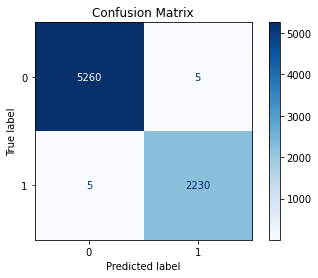

In [172]:
RF_wrapper(df)

In [173]:
class TestWrapper(unittest.TestCase):
    
    def test_wrapper_input(self):
        #test that input data type is correct
        try:
            RF_wrapper([1,2,3])
            self.assertTrue(False)
        except AssertionError:
            self.assertTrue(True)

    def test_wrapper_output(self):
        model, _, _, test_X, test_y = train_model(
            df, 
            columns=input_features, target='protein_match'
        )
        # assert output type is correct
        output = evaluate_model(model, test_X, test_y)
        self.assertIsInstance(output, np.ndarray)
        
    def test_output_dimension(self):
        model, _, _, test_X, test_y = train_model(
            df, 
            columns=input_features, target='protein_match'
        )
        # want to check that the number of predictions is equal to the number of test examples
        preds = evaluate_model(model, test_X, test_y)
        self.assertEqual(len(test_y), len(preds))
        

suite = unittest.TestLoader().loadTestsFromTestCase(TestWrapper)
_ = unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 6.192s

OK


**IGNORE BELOW**

In [35]:
# #plot empirical distribution of scaled_local_query_percent_id

# target = df['protein_match']
# #create histplot
# fig, ax = plt.subplots()

# sns.histplot(data = df, x = target)

# ax.set_title('Sample Histogram', fontsize=16)
# ax.set_xlabel('Class', fontsize=14)
# ax.set_ylabel('Count', fontsize=14)

Things I've tried to improve model: 

1. drop bit scores over 1000
2. Switch to 85/15 train/test split
3. Lasso regression - not great
4. Ridge regression - R2 = 0.87, about the same as normal Linear regression
5. KNN regression (n_neighbors optimized at 8) gives best result, R2 = ~0.93 --> 
*got it up to .942 by removing a few features
6. Decision tree regressor was slightly worse than KNN
7. Input DT classifier and RF classifier. RF classifier has best performance
8. Changed target to binary protein function match